<a href="https://colab.research.google.com/github/karthik2027/-REAL-TIME-VEHICLE-CLASSIFICATION-AND-LOCALIZATION-USING-EDGE-COMPUTING-/blob/master/eeg_drow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install -U git+https://github.com/keras-team/keras-applications

In [0]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model 
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
%matplotlib inline 

In [0]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 4
NO_EPOCHS = 30
NUM_CLASSES = 3
SAMPLE_SIZE_TRAIN = 343
SAMPLE_SIZE_TEST = 3 
PATH = '/content/drive/My Drive/data_all.zip (Unzipped Files)/'
TRAIN_FOLDER = PATH + 'Train'
TEST_FOLDER = PATH + 'Test'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
train_image_list = os.listdir(TRAIN_FOLDER)[0:SAMPLE_SIZE_TRAIN]

In [0]:
test_image_list = os.listdir(TEST_FOLDER)[0:SAMPLE_SIZE_TEST]

In [0]:
def label_pet_image_one_hot_encoder(img):
    state = img[0:3]
    if state == 'asl': return [1,0,0]
    elif state == 'awa': return [0,1,0]
    elif state == 'dro': return [0,0,1]

In [0]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [10]:
"""def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)"""

"def plot_image_list_count(data_image_list):\n    labels = []\n    for img in data_image_list:\n        labels.append(img.split('.')[-3])\n    sns.countplot(labels)\n    plt.title('Cats and Dogs')\n    \nplot_image_list_count(train_image_list)"

In [0]:
#plot_image_list_count(os.listdir(TRAIN_FOLDER))

In [31]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 343/343 [00:03<00:00, 105.01it/s]


In [32]:
test = process_data(test_image_list, TEST_FOLDER, False)

100%|██████████| 3/3 [00:00<00:00, 79.68it/s]


In [0]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [34]:
res_50_model = ResNet50(weights='imagenet', include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
#model.add(Dropout(0.01))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

In [0]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE,shuffle=True)

In [0]:
filepath="weights.best.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') 
callbacks_list = [checkpoint]

In [54]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  callbacks= callbacks_list,
                  validation_data=(X_val, y_val))


Train on 171 samples, validate on 172 samples
Epoch 1/30
168/171 [============================>.] - ETA: 0s - loss: 0.2314 - acc: 0.9226
Epoch 00001: val_acc improved from -inf to 0.58721, saving model to weights.best.hdf5
171/171 [==============================] - 14s 85ms/sample - loss: 0.2301 - acc: 0.9240 - val_loss: 2.0169 - val_acc: 0.5872
Epoch 2/30
168/171 [============================>.] - ETA: 0s - loss: 0.0825 - acc: 0.9821
Epoch 00002: val_acc improved from 0.58721 to 0.80233, saving model to weights.best.hdf5
171/171 [==============================] - 10s 58ms/sample - loss: 0.0813 - acc: 0.9825 - val_loss: 0.9609 - val_acc: 0.8023
Epoch 3/30
168/171 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9881
Epoch 00003: val_acc did not improve from 0.80233
171/171 [==============================] - 9s 56ms/sample - loss: 0.0316 - acc: 0.9883 - val_loss: 0.9469 - val_acc: 0.7733
Epoch 4/30
168/171 [============================>.] - ETA: 0s - loss: 0.0113 - acc

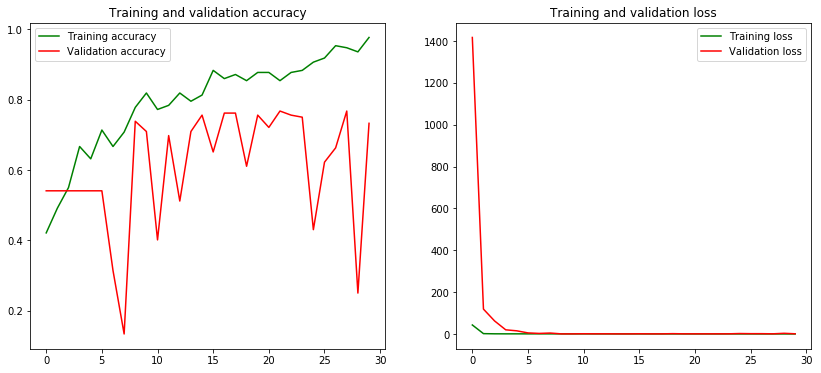

In [39]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)


In [40]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.000887856927029
Validation accuracy: 0.73255813


In [0]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [0]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [43]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))


              precision    recall  f1-score   support

    Class 0:       0.86      0.72      0.78        93
    Class 1:       0.81      0.84      0.82        25
    Class 2:       0.56      0.70      0.62        54

    accuracy                           0.73       172
   macro avg       0.74      0.75      0.74       172
weighted avg       0.76      0.73      0.74       172



In [47]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    print(predicted)
    img_list.append(img_idx)
    pred_list.append(predicted)

100%|██████████| 3/3 [00:00<00:00, 17.85it/s]

[0.9619114  0.02033411 0.01775445]
[4.3520786e-06 9.9687237e-01 3.1232503e-03]
[0.5373747  0.10406143 0.35856387]


In [45]:
pred_list

[0.020334108, 0.99687237, 0.10406143]

In [46]:
img_list

[array('drowsy (55)', dtype='<U11'),
 array('awake (3)', dtype='<U9'),
 array('asleep (1)', dtype='<U10')]